# import functions

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import pandas as pd
import os,sys,glob, h5py

from dlab import generalephys as ephys
from dlab.generalephys import placeAxesOnGrid, cleanAxes
#from dlab import utils
from dlab import rf_analysis
from dlab import psth_and_raster as psth
from dlab import reliability_and_precision as rp
from dlab.continuous_traces import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.stats import pearsonr, spearmanr, zscore
from itertools import combinations 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import pandas as pd
import os,io,sys,glob, h5py, csv, time
import matplotlib.pyplot as plt
import json

from dlab import generalephys as ephys
from dlab import generalephys_mua as ephys_mua

from dlab import utils_pipeline as utils
#from dlab import utils_mua

from dlab.continuous_traces import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.stats import pearsonr, spearmanr, zscore
from itertools import combinations 
from dlab import sorting_quality_editing as sq
from sklearn.manifold import TSNE
from scipy.cluster.vq import kmeans2
from dlab import preprocessing_pipeline as preprocessing
from dlab import depth_estimation as depth

import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# pipeline code to reference

In [11]:
def synchphys(software_start,frame_timestamps,samplerate = 30000):
#synch the ephys with the behavior to find reachmax timessoftware_start = 56549737/30000 #convert software start time in samples to seconds
    st = software_start/samplerate
    ts_sec = frame_timestamps/samplerate # convert frame timestamps to seconds
    ts_z = ts_sec - st #subtract software start from frames
    reachmax = np.array(df_reaches.reachMax)
    reachmax = reachmax[~np.isnan(reachmax)]
    reachmax = reachmax.astype('int')
    reach_times = ts_z[reachmax]
    return(reach_times)
  
    
def epochfr(df,df_reaches,start,end,binsize=0.020):
    ## if epoch is BEFORE reachmax (such as baseline) then end variable must be input as negative as per code (i.e. end = -0.5)
    
    byreach=np.zeros((len(df),1))
    maxfr_ind=np.zeros((len(df),1))
    peakfr_max=np.zeros((len(df),1))
    peakfr_min=np.zeros((len(df),1))
    rd = []
    frs = []
    tops = []
    frmaxs = []
    frmins = []
    
    for i,times in enumerate(df.times): #for each unit 
        t = np.array(times) #for reach unit create an array of that unit's spike times
        for j,tmax in enumerate(df_reaches.rMax_t): #compare that unit's spike times to each reach max
            #rd = np.array(t[(t >= tmax-start) & (t <= tmax+end)]) #find if that unit spiked within designated timeframes around reachmax
            rd = np.array(t[(t >= tmax+start) & (t <= tmax+end)]) #find if that unit spiked within designated timeframes around reachmax
            #edges=np.arange(tmax-start,tmax+end,binsize) #designated bins around specific iteration of reachmax
            edges=np.arange(tmax+start,tmax+end,binsize)
            hist=np.histogram(rd,edges)[0] #bin spikes into timeframe
            top = np.argmax(hist)
            fr = sum(hist)/abs(end-start) # in Hz ######????????????
            frs.extend([fr])
            tops.extend([top])
            frmax = np.max(hist)/binsize
            frmin = np.min(hist)/binsize
            frmaxs.append(frmax)
            frmins.append(frmin)
        meanfr = np.mean(frs)
        tops_ave = np.mean(tops)
        maxs = np.mean(frmaxs)
        mins = np.mean(frmins)
        frs = []
        tops=[]
        frmaxs = []
        frmins = []
        maxfr_ind[i,:] = tops_ave
        byreach[i,:] = meanfr
        peakfr_max[i,:] = maxs
        peakfr_min[i,:] = mins
    return byreach, peakfr_max, peakfr_min


def epochfr_baseline(df,df_reaches,start,end,binsize=0.020):
    ## if epoch is BEFORE reachmax (such as baseline) then end variable must be input as negative as per code (i.e. end = -0.5)
    
    byreach=np.zeros((len(df),1))
    rd = []
    frs = []
    
    for i,times in enumerate(df.times): #for each unit 
        t = np.array(times) #for reach unit create an array of that unit's spike times
        for j,tmax in enumerate(df_reaches.rMax_t): #compare that unit's spike times to each reach max
            #rd = np.array(t[(t >= tmax-start) & (t <= tmax+end)]) #find if that unit spiked within designated timeframes around reachmax
            rd = np.array(t[(t >= tmax+start) & (t <= tmax+end)]) #find if that unit spiked within designated timeframes around reachmax
            #edges=np.arange(tmax-start,tmax+end,binsize) #designated bins around specific iteration of reachmax
            edges=np.arange(tmax+start,tmax+end,binsize)
            hist=np.histogram(rd,edges)[0] #bin spikes into timeframe
            fr = sum(hist)/abs(end-start) ######????????????????????????????????????????? 
            frs.extend([fr])
        meanfr = np.mean(frs)
        frs = []
        byreach[i,:] = meanfr
    return byreach


def reachave_bins(df,df_reaches,start,end,binsize=0.020): #DO NOT USE
    #collapses mean fr along bins and normalizes
    #start and end variables are negative if before reachmax (i.e. baseline)
    asdfasdfasdf
    #initialize 
    ave_reach = []
    normedbins = []
    edges=np.arange(start,end,binsize)
    num_bins=edges.shape[0]-1 #number of bins 
    ave_reach_tens=np.zeros((len(df),num_bins)) #for tensor

    for i,times in enumerate(df.times): #for each unit 
        t = np.array(times) #for reach unit create an array of that unit's spike times
        for j,tmax in enumerate(df_reaches.rMax_t): #compare that unit's spike times to each reach max
            rd = np.array(t[(t >= tmax+start) & (t <= tmax+end)]) #find if that unit spiked within designated timeframes around reachmax
            edges=np.arange(tmax+start,tmax+end,binsize) #designated bins around this iteration of reachmax
            num_bins=edges.shape[0]-1 #number of bins 
            byreach=np.zeros((len(df_reaches.rMax_t),num_bins)) #initialize or empty byreach
            hist=np.histogram(rd,edges)[0] #bin spikes into timeframe
            byreach[j,:] = hist
        meanbinfr = np.mean(byreach,axis=0)
        if sum(meanbinfr) > 0: 
            ave_reach.append(meanbinfr)
            ave_reach_tens[i,:] = meanbinfr #for tensor purposes (neural trajectories)
            normbins = (meanbinfr-min(meanbinfr))/max(meanbinfr) #per dailey
            normedbins.append(normbins)
    
    return ave_reach, normedbins, ave_reach_tens



def reachave_tensor(df,df_reaches,binsize=0.020, start = 4.0,end = 2.0):
    #START IS TIME BEFORE REACHMAX
    #END IS TIME AFTER REACHMAX -- IF BEFORE REACHMAX THEN END MUST BE NEGATIVE
    #collapses mean fr along bins
    #initialize 
    edges=np.arange(-start,end,binsize)
    num_bins=edges.shape[0]-1 #number of bins 
    byreach=np.zeros((len(df_reaches.rMax_t),num_bins))
    ave_reach_=np.zeros((len(df),num_bins)) #for tensor purposes
    ave_reach = []
    normedbins = []

    for i,times in enumerate(df.times): #for each unit 
        t = np.array(times) #for reach unit create an array of that unit's spike times
        for j,tmax in enumerate(df_reaches.rMax_t): #compare that unit's spike times to each reach max
            rd = np.array(t[(t >= tmax-start) & (t <= tmax+end)]) #find if that unit spiked within designated timeframes around reachmax
            edges=np.arange(tmax-start,tmax+end,binsize) #designated bins around this iteration of reachmax
            hist=np.histogram(rd,edges)[0] #bin spikes into timeframe
            byreach[j,:] = hist
        meanbinfr = np.mean(byreach,axis=0)
        ave_reach.append(meanbinfr)
    
        ave_reach_[i,:] = meanbinfr #for tensor purposes (neural trajectories)
    
        normbins = (meanbinfr-min(meanbinfr))/max(meanbinfr) #per dailey
        normedbins.append(normbins)
    
        byreach=np.zeros((len(df_reaches.rMax_t),num_bins))

    return ave_reach, normedbins, ave_reach_



def countlist(lst): #to count consecutive numbers in movement-related code
    streak_count = []
    counter = 1
    for i in range(len(lst)):
        if i != (len(lst) - 1):
            diff = lst[i+1] - lst[i]
            if diff == 1:
                counter += 1
            else:
                streak_count.append(counter)
                counter = 1
        else:
            streak_count.append(counter)
    return(streak_count)



def movement_mod(df,df_reaches,startb,endb,starte,ende,binsize=0.001): #binsize 1 ms
    
    edgesb=np.arange(startb,endb,binsize)
    num_binsb=edgesb.shape[0]-1 #number of bins

    edgese=np.arange(starte,ende,binsize)
    num_binse=edgese.shape[0]-1 #number of bins

    byreach_b=np.zeros((len(df_reaches.rMax_t),num_binsb))
    byreach_e=np.zeros((len(df_reaches.rMax_t),num_binse))

    mod_up = []
    mod_down = []
    maxfr_ts = []
    minfr_ts = []
    maxfrs = []

    for i,times in enumerate(df.times): #for each unit 
        t = np.array(times) #for reach unit create an array of that unit's spike times
    
        for j,tmax in enumerate(df_reaches.rMax_t): 
        
            base = np.array(t[(t >= tmax+startb) & (t <= tmax+endb)])
            epoch = np.array(t[(t >= tmax+starte) & (t <= tmax+ende)])
        
            edgesb = np.arange(tmax+startb,tmax+endb,binsize)
            edgese = np.arange(tmax+starte,tmax+ende,binsize)
        
            histb=np.histogram(base,edgesb)[0] 
            histe=np.histogram(epoch,edgese)[0]
    
            byreach_b[j,:] = histb
            byreach_e[j,:] = histe
    
        meanbinfr_b = np.mean(byreach_b,axis=0)
        mfrb_ser = pd.Series(meanbinfr_b)        
        rolave_mfrb = mfrb_ser.rolling(100).sum() #takes sum of 100bins, shifts 1bin .. 100 bins binned at 1 ms = 100ms summed bins
        rolave_mfrb = np.array(rolave_mfrb.dropna())
        #lower,upper = sms.DescrStatsW(rolave_mfrb).tconfint_mean() #fix this
        upper = np.mean(rolave_mfrb) + (2.56*std(rolave_mfrb))
        lower = np.mean(rolave_mfrb) - (2.56*std(rolave_mfrb))

        meanbinfr_e = np.mean(byreach_e,axis=0)
        mfr_ser = pd.Series(meanbinfr_e)        
        rolave_mfr = mfr_ser.rolling(100).sum() #takes sum of 100bins, shifts 1bin
        maxfr = np.max(rolave_mfr)/.1
        maxfr_t = edgese[np.argmax(rolave_mfr)]-tmax
        minfr_t = edgese[np.argmin(rolave_mfr)]-tmax
        
        maxfrs.append(maxfr)
        maxfr_ts.append(maxfr_t)
        minfr_ts.append(minfr_t)

        mfr_a = np.array(rolave_mfr)
        up = np.where(mfr_a >= upper)[0].tolist()
        down = np.where(mfr_a <= lower)[0].tolist()

        consec_up = np.array(countlist(up))
        consec_down = np.array(countlist(down))

        if any(consec_up >= 50): #if there are 50 consecutive bins
            ups = 'yes'
            mod_up.append(ups)
        else:
            ups_ = 'no'
            mod_up.append(ups_)
    
        if any(consec_down >= 50): #if there are 50 consecutive bins
            downs = 'yes'
            mod_down.append(downs)
        else:
            downs_ = 'no'
            mod_down.append(downs_)

    return mod_up, mod_down, maxfr_ts, minfr_ts, maxfrs



#mean removes and normalizes to std
def center(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xc = ss.fit_transform(X.T).T
    return Xc



def pca(tens):
    for i in range(min(tens.shape[0], tens.shape[1])-1):
        pca = PCA(n_components=i)
        p=pca.fit_transform(tens.T).T
        ev = (pca.explained_variance_ / sum(pca.explained_variance_))
    return p,ev

# load files

In [19]:
folder = r'C:\Recordings\SortedRecordings\open-ephys-neuropix_CFA_08\2021-11-03_12-25-30\experiment1\recording1\continuous\Neuropix-PXI-100.0\truncated'

In [23]:
df = preprocessing.df_from_phy(folder,expnum='1',recnum='1')

In [25]:
df['mouse'] = 8
df['cohort'] = 'CFA'

In [26]:
df.to_json(r'C:\Recordings\SortedRecordings\open-ephys-neuropix_CFA_08\2021-11-03_12-25-30\experiment1\recording1\continuous\Neuropix-PXI-100.0\truncated\df.json')

In [405]:
#only need to load this once when you're running data
#load processor start times
p_start = r'/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/finalized/Neuropixels_ProcessorStartTimes.csv'
df_start = pd.read_csv(p_start)
#df_start

In [406]:
#load dataframe from sorted data
data_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/dfs/dfexcept28_ypos.json'
df = pd.read_json(data_path)

In [417]:
#load TTL frame timestamps
ts_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/finalized/Video TTL Files/18_timestamps.npy'
#ts = np.loadtxt(ts_path) #if .txt
ts =np.load(ts_path) #if .npy

In [3]:
#import curated behavior for specific mouse (save .xls as .csv)
reach_path = '/Users/kimberlygagnon/Documents/CU/WelleLab/experiments/daileydata/finalized/Curated_Video_Timestamps/20200214_unit00_session002_NPCB_018_S2.csv'
df_reaches = pd.read_csv(reach_path)

In [4]:
df_reaches

,reachInit,reachMax,reachEnd,stim,end_category,behaviors
0,47840,47866,47946,0,noPellet,retrieval_fail
1,49976,50001,50052,0,noPellet,retrieval_fail
2,52909,52935,53002,0,noPellet,grasp_fail
3,82485,82525,82532,0,noPellet,grasp_fail
4,84353,84374,84400,0,noPellet,grasp_fail
5,93312,93325,93334,0,noPellet,grasp_fail
6,101711,101730,101740,0,noPellet,grasp_fail
7,110153,110186,110261,0,noPellet,success
8,112616,112641,112698,0,noPellet,grasp_fail
9,124717,124738,124757,0,noPellet,grasp_fail


In [10]:
for i in df_reaches.index:
    end_ = df_reaches.reachEnd[i]
    init = df_reaches.reachInit[i+1]
    diff

49976 47946
52909 50052
82485 53002
84353 82532
93312 84400
101711 93334
110153 101740
112616 110261
124717 112698
133716 124757
142370 133802
172287 142408
174162 172350
177380 174235
193556 177427
201155 193624
204238 201278
206920 204258
231068 206940
244395 231183
245233 244504
261477 245320
277418 261497
290441 277520
293551 290670
312255 293684
329548 312295
331346 329596
127040 331413
129837 127170
296903 129917


KeyError: 32

# run pipeline code

In [3]:
timestamp_path = r'C:\Recordings\SortedRecordings\open-ephys-neuropix_CFA_08\2021-11-03_12-25-30\experiment1\recording1\events\Neuropix-PXI-100.0\TTL_1\timestamps.npy'
ts = np.load(timestamp_path)

In [4]:
df_reaches =  pd.read_json(r'C:\Users\Kim\Documents\Data\behavior\df_reaches.json')

In [5]:
#change mouse number you want to analyze
mouse = 8

In [410]:
df=df[df.mouse==mouse] #isolates mouse from dataframe to analyze


In [418]:
np.shape(ts) #number of timestamps


(972236,)

In [6]:
4#adjust timestamps if necessary

ts_lst = ts.tolist()
del ts_lst[1::2] #remove odd indices
ts = np.array(ts_lst)

In [7]:
#remove irrelevant behaviors and nans
df_reaches = df_reaches.dropna(axis = 1 , how = 'all')
df_reaches = df_reaches.dropna(axis = 0 , how = 'all')
df_reaches = df_reaches[df_reaches.behaviors!='none'][df_reaches.behaviors!='arm_movement']


In [12]:
#synch ephys with behavior
#sst = np.int(df_start[df_start.Mouse_number==mouse].Proccessor_Start_time)
sst = sst = 50940699
reach_times = synchphys(sst,ts)
print(sst)


50940699


In [13]:
df_reaches['rMax_t']= reach_times #create new column of reach dataframe with reach times in seconds to compare to spike times


In [14]:
df_reaches

,reachInit,reachMax,reachEnd,stim,end_category,behaviors,mouse,cohort,rMax_t
0,3815,3831,3851,0,newReach,grasp_fail,8,CFA,33.016867
1,3825,3829,3843,0,reachLost,grasp_fail,8,CFA,33.003533
2,7627,7634,7721,0,handLost,success,8,CFA,58.372800
3,48349,48357,48743,0,handLost,retrieval_fail,8,CFA,329.886867
4,57001,57012,57046,0,handLost,success,8,CFA,387.592733
5,68808,68818,68843,0,noPellet,grasp_fail,8,CFA,466.307367
6,77429,77441,77475,0,handStop,success,8,CFA,523.799800
7,124730,124744,124735,0,reachLost,retrieval_fail,8,CFA,839.185033
8,135292,135308,135340,0,handStop,retrieval_fail,8,CFA,909.618833
9,135727,135736,135758,0,noPellet,success,8,CFA,912.472433


In [105]:
df_reaches = df_reaches[df_reaches.behaviors!='success']


In [430]:
#creates dataframe to feed results into
df_align = pd.DataFrame(df,columns = ['times','ypos','mouse','cohort','cell','overall_rate','waveform_class','baseline_fr','reach_fr'])

In [431]:
#functions calculate epoch firing rates and movement-related neurons, feeds into dataframe
reaches,b,c = epochfr(df,df_reaches,start = -0.5,end = 0.5,binsize=0.020)
df_align['reach_fr'] = reaches
df_align['maxfr'] = b
df_align['minfr'] = c
baseline = epochfr_baseline(df,df_reaches,start = -1.0,end = -0.5,binsize=0.020) 
df_align['baseline_fr'] = baseline
ave_reach,normedbins,ave_reach_ = reachave_tensor(df,df_reaches)
df_align['bin_ave'] = ave_reach
df_align['norm_bin_ave'] = normedbins
mod_up, mod_down, maxfr_ts, minfr_ts, a = movement_mod(df,df_reaches,startb = -1.0,endb = -0.5,starte = -0.5,ende = 0.5,binsize=0.001)
df_align['mod_up'] = mod_up
df_align['mod_down'] = mod_down
df_align['peakfr_up'] = maxfr_ts
df_align['peakfr_down'] = minfr_ts
df_align['maxfr_rolave'] = a
#centr_traj = center(ave_reach_)
#traj,ev = pca(centr_traj)
#smooth_pcs = gaussian_filter1d(p, sigma=8)

In [199]:
df_reaches = df_reaches.reset_index()

In [200]:
start = 4
end = 10
binsize = 0.020
edges=np.arange(-start,end,binsize)
num_bins=edges.shape[0] #number of bins 
byreach=np.zeros((shape(df)[0],num_bins))
alltrials = []
trajs = []
evs = []
outcomes = []

for j,tmax in enumerate(df_reaches.rMax_t): #compare that unit's spike times to each reach max
    a = tmax-start
    b = tmax+end
    byreach=np.zeros((shape(df)[0],num_bins))
    for i,times in enumerate(df.times): #for each unit 
        t = np.array(times) #for reach unit create an array of that unit's spike times
        try:
            rd = np.array(t[(t >= a) & (t <= b)]) #find if that unit spiked within designated timeframes around reachmax
            edges=np.arange(a,b,binsize) #designated bins around this iteration of reachmax
            num_bins=edges.shape[0]-1 #number of bins 
            hist=np.histogram(rd,edges)[0] #bin spikes into timeframe
            byreach[i,:] = hist
        except:
            print('miss', j)
            
    #normbins = (meanbinfr-min(meanbinfr))/max(meanbinfr) #per dailey
    #normedbins.append(normbins)
    alltrials.append(byreach)
    
    #center_traj = center(byreach)
    #traj,ev = pca(center_traj)
    #traj = gaussian_filter1d(traj, sigma=8)
    #trajs.append(traj)
    #evs.append(ev)
    #outcome = df_reaches.behaviors[j]
    #outcomes.append(outcome)

miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0
miss 0

In [202]:
df_reaches['bins'] = alltrials

# by trial heatmap

In [378]:
df_reaches.reset_index()

,index,reachInit,reachMax,reachEnd,stim,end_category,behaviors,rMax_t
0,0,47840,47866,47946,0,noPellet,retrieval_fail,322.847467
1,1,49976,50001,50052,0,noPellet,retrieval_fail,337.082233
2,2,52909,52935,53002,0,noPellet,grasp_fail,356.644167
3,3,82485,82525,82532,0,noPellet,grasp_fail,553.930667
4,4,84353,84374,84400,0,noPellet,grasp_fail,566.258567
5,5,93312,93325,93334,0,noPellet,grasp_fail,625.770900
6,6,101711,101730,101740,0,noPellet,grasp_fail,681.809867
7,7,110153,110186,110261,0,noPellet,success,738.188867
8,8,112616,112641,112698,0,noPellet,grasp_fail,754.557167
9,9,124717,124738,124757,0,noPellet,grasp_fail,835.211933


In [399]:
# label reachmax

# smooth?

# look at sequence

def bytrial_heatmap(df,df_reaches,start,end):
    
    edgest=np.arange(start,end,0.020)
    num_binst=(edgest.shape[0]) #number of bins 
    hmap=np.zeros((shape(df)[0],num_binst))
    #hmap_rollave=np.zeros((shape(df)[0],num_bins))
    byreach = []
    rollave = []
    maxfr_ts = []
    minfr_ts = []
    maxfrs = []
    normedbins = []
    normedbins_roll = []
    inds = []
    
    for j,tmax in enumerate(df_reaches.rMax_t): #compare that unit's spike times to each reach max

        hmap=np.zeros((shape(df)[0],num_binst))
        byreach = []
        rollave = []
        maxfr_ts = []
        minfr_ts = []
        maxfrs = []
        normedbins = []

        a = tmax+start
        b = tmax+end

        trial_outcome = j, df_reaches.behaviors[j]

        for i,times in enumerate(df.times): #for each unit 
            t = np.array(times) #for reach unit create an array of that unit's spike times
            binsize = 0.020
            rd = np.array(t[(t >= a) & (t <= b)]) #find if that unit spiked within designated timeframes around reachmax
            edges=np.arange(a,b,binsize) #designated bins around this iteration of reachmax
            num_bins=edges.shape[0]-1 #number of bins 
            hist=np.histogram(rd,edges)[0] #bin spikes into timeframe
            #hmap[i,:] = hist
            byreach.append(hist)

            if sum(hist)>0:
                normbins = (hist-min(hist))/max(hist) #per dailey
                normedbins.append(normbins)
            else:
                normedbins.append(None)


            binsize_ = 0.001
            edges_=np.arange(a,b,binsize_) #designated bins around this iteration of reachmax
            num_bins_=edges_.shape[0]-1 #number of bins 
            unit=np.histogram(rd,edges_)[0] #bin spikes into timeframe
            unit_ser = pd.Series(unit)        
            rolave_unit = unit_ser.rolling(100).sum() #takes sum of 100bins, shifts 1bin .. 100 bins binned at 1 ms = 100ms summed bins
            rolave_unit = np.array(rolave_unit.dropna())
            maxfr = np.max(rolave_unit)/.1
            maxfr_t = edges_[np.argmax(rolave_unit)]-tmax
            minfr_t = edges_[np.argmin(rolave_unit)]-tmax
            #hmap_rollave[i,:] = unit
            rollave.append(unit)
            maxfrs.append(maxfr)
            maxfr_ts.append(maxfr_t)
            minfr_ts.append(minfr_t)

        df_temp = pd.DataFrame(data=minfr_ts,columns=['tmin'])
        df_temp['bins'] = normedbins
        df_temp['tmax'] = maxfr_ts

        #df_s = df_temp.sort_values(by=['tmin'])
        #df_bins = df_s.bins
        #df_heatmap = list(filter(any, df_bins))
        #fig, ax = plt.subplots(figsize=(20, 10))
        #sns.heatmap(df_heatmap)
        #plt.title(trial_outcome)
        #plt.show()
        #save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/cs1cs2_reran/'
        #fig.savefig(save_path+str(mouse)+'_cs1_downmod_'+str('_') +str(i)+str('_') +str(start)+str('_') +str(end)+'.png')
        #plt.close()

        df_s_ = df_temp.sort_values(by=['tmax'])
        df_bins_ = df_s_.bins
        #ind = df_s_.index
        #inds.append(ind)
        df_heatmap_ = list(filter(any, df_bins_))
        fig, ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(df_heatmap_)
        plt.title(trial_outcome)
        plt.gca().axvline(100,c='b',ls='-')
        save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/cs1cs2_reran/'
        #fig.savefig(save_path+str(mouse)+'_cs1_upmod_'+str('_') +str(i)+str('_') +str(start)+str('_') +str(end)+'.png')
        plt.show()
        plt.close()

In [402]:
bytrial_heatmap(df,df_reaches,-2,4,save=True)

TypeError: bytrial_heatmap() got an unexpected keyword argument 'save'

IndexError: index 2 is out of bounds for axis 0 with size 2

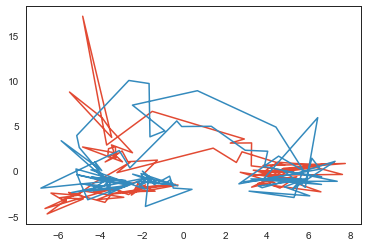

In [173]:
x = df_reaches.traj
y = df_reaches.traj

#x = df_reaches[df_reaches.behaviors=='success'].traj
#y = df_reaches[df_reaches.behaviors=='success'].traj

x_ = df_reaches[df_reaches.behaviors=='success'].traj
y_ = df_reaches[df_reaches.behaviors=='success'].traj


#ax = plt.axes(projection='3d')
plt.figure()
for i,trajs in enumerate(x):
    ind = df_reaches[df_reaches.behaviors=='success'].index[i]
    plt.plot(x[ind][0],y[ind][1])
    #plt.plot(x_[i][0],y_[i][1],'r')

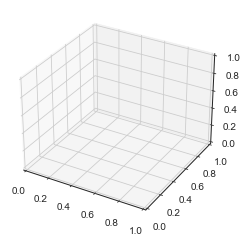

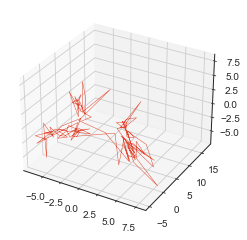

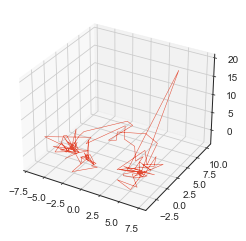

<Figure size 432x288 with 0 Axes>

In [172]:
#x = df_reaches.traj
#y = df_reaches.traj
#z = df_reaches.traj

x = df_reaches[df_reaches.behaviors=='success'].traj
y = df_reaches[df_reaches.behaviors=='success'].traj
z = df_reaches[df_reaches.behaviors=='success'].traj



ax = plt.axes(projection='3d')
fig = plt.figure()
for i,trajs in enumerate(x):
    ax = plt.axes(projection='3d')
    fig = plt.figure()
    #ax.set_xlim3d(-6, 8)
    #ax.set_ylim3d(-6, 8)
    #ax.set_zlim3d(-6, 8)
    ind = df_reaches[df_reaches.behaviors=='success'].index[i]
    ax.plot3D(x[ind][0],y[ind][1],z[ind][2],linewidth=.5)

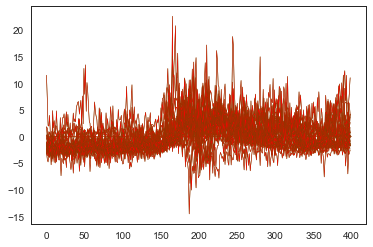

In [188]:
x = df_reaches.traj
y = df_reaches.traj

#x = df_reaches[df_reaches.behaviors=='success'].traj
#y = df_reaches[df_reaches.behaviors!='success'].traj


plt.figure()
for i,trajs in enumerate(x):
    #inds = df_reaches[df_reaches.behaviors=='success'].index[i]
    #try:
        #indf = df_reaches[df_reaches.behaviors!='success'].index[i]
    #except:
        #print('none')
    plt.plot(x[i][1],'g',linewidth=.5)
    plt.plot(y[i][1],'r',linewidth=.5)

In [147]:
df_reaches.to_json('/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/18_df_reaches_singletrial.json')


In [27]:
#trial_s= ave_reach_
trial_f = ave_reach_



In [42]:
concat = np.concatenate((trial_s,trial_f),axis=1)


In [45]:
centr_traj = center(concat)
traj,ev = pca(centr_traj)

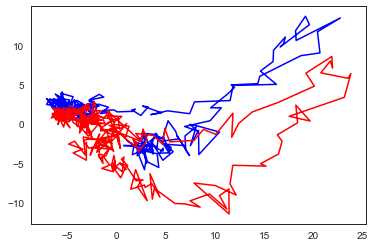

In [55]:
plt.plot(traj[0][:299],traj[1][:299],'b')
plt.plot(traj[0][299:],traj[1][299:],'r')

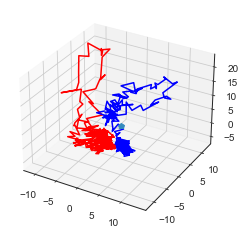

In [81]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(traj[2][299:],traj[1][299:],traj[0][299:],'r')
ax.plot3D(traj[2][0],traj[1][0],traj[0][0],'p')
ax.plot3D(traj[1][:299],traj[2][:299],traj[0][:299],'b')
ax.plot3D(traj[2][0],traj[1][0],traj[1][0],'p')

save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/3d/' 
#plt.savefig(save_path+str('20_bot_3d')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

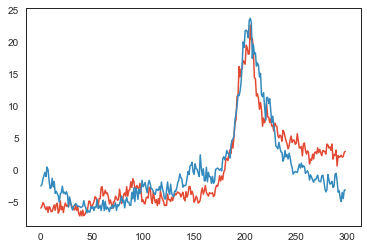

In [59]:
plt.plot(traj[0][:299])
plt.plot(traj[0][299:])


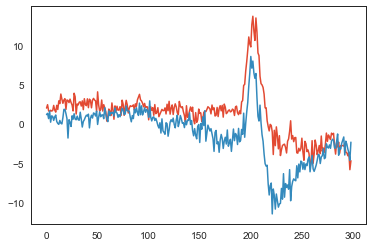

In [60]:
plt.plot(traj[1][:299])
plt.plot(traj[1][299:])

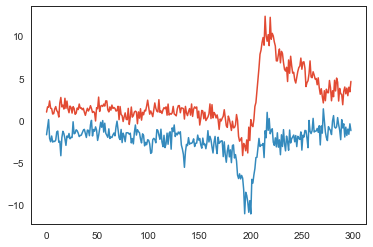

In [61]:
plt.plot(traj[2][:299])
plt.plot(traj[2][299:])

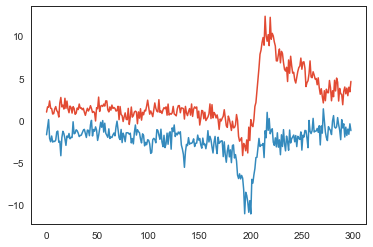

In [66]:
plt.plot(traj[2][:299])
plt.plot(traj[2][299:])

# plot random movement-related stuff

In [12]:
df_up = df[df.mod_up=='yes'] #modulated up
df_down = df[df.mod_down=='yes'] #modulated down
df_onlyup = df[df.mod_up=='yes'][df.mod_down=='no'] #ONLY modulated up
df_onlydown = df[df.mod_down=='yes'][df.mod_up=='no']
df_updown = df[df.mod_up=='yes'][df.mod_down=='yes'][df.mod_down!='no'][df.mod_up!='no'] #modulated up and down

Text(0.5, 1.0, 'firing rate for movement-related neurons')

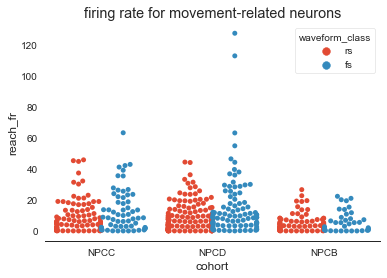

In [38]:
sns.swarmplot(x="cohort", y="reach_fr", hue="waveform_class",
               split=True, 
#                palette={"Yes": "y", "No": "b"},
                             data=df_up[df.waveform_class!='up'][df.waveform_class!='axon'])
sns.despine(left=True)
plt.title('firing rate for movement-related neurons')

Text(0.5, 1.0, 'firing rate for down-modulated neurons')

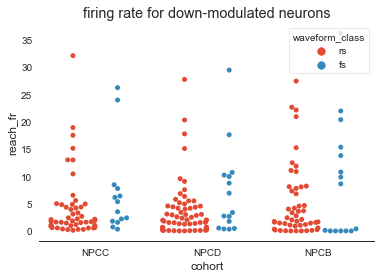

In [35]:
sns.swarmplot(x="cohort", y="reach_fr", hue="waveform_class",
               split=True, 
#                palette={"Yes": "y", "No": "b"},
                             data=df_down[df.waveform_class!='up'][df.waveform_class!='axon'])
sns.despine(left=True)
plt.title('firing rate for down-modulated neurons')

Text(0.5, 1.0, 'firing rate for down-modulated neurons')

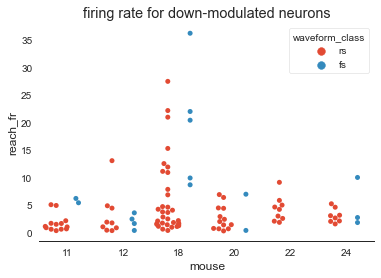

In [34]:
sns.swarmplot(x="mouse", y="reach_fr", hue="waveform_class",
               split=True, 
#                palette={"Yes": "y", "No": "b"},
                             data=df_onlydown[df.waveform_class!='up'][df.waveform_class!='axon'])
sns.despine(left=True)
plt.title('firing rate for down-modulated neurons')

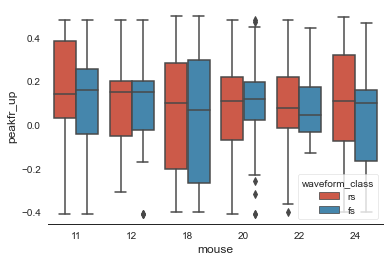

In [14]:
sns.boxplot(x="mouse", y="peakfr_up", hue="waveform_class", 
                data=df_up[df_up.waveform_class!='up'][df_up.waveform_class!='axon'])
sns.despine(left=True)

Text(0.5, 1.0, 'time of peak firing rate for movement-related neurons')

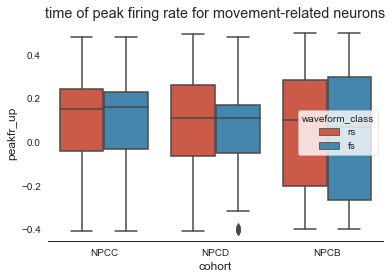

In [32]:
sns.boxplot(x="cohort", y="peakfr_up", hue="waveform_class", 
                data=df_up[df_up.waveform_class!='up'][df_up.waveform_class!='axon'])
sns.despine(left=True)
plt.title('time of peak firing rate for movement-related neurons')

Text(0.5, 1.0, 'reach firing rate for biphasic neurons')

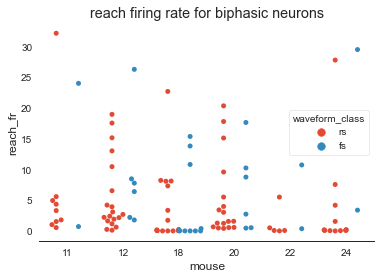

In [25]:
sns.swarmplot(x="mouse", y="reach_fr", hue="waveform_class",
               split=True, 
#                palette={"Yes": "y", "No": "b"},
                             data=df_updown[df.waveform_class!='up'][df.waveform_class!='axon'])
sns.despine(left=True)
plt.title('reach firing rate for biphasic neurons')

Text(0.5, 1.0, 'time of peak firing rate during reach for biphasic neurons')

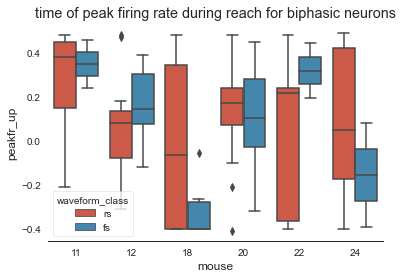

In [26]:
sns.boxplot(x="mouse", y="peakfr_up", hue="waveform_class", 
                data=df_updown[df_up.waveform_class!='up'][df_updown.waveform_class!='axon'])
sns.despine(left=True)
plt.title('time of peak firing rate during reach for biphasic neurons')

Text(0.5, 1.0, 'time of minimum firing rate during reach for biphasic neurons')

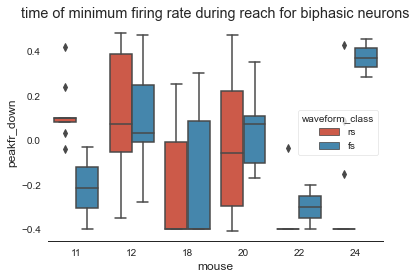

In [27]:
sns.boxplot(x="mouse", y="peakfr_down", hue="waveform_class", 
                data=df_updown[df_up.waveform_class!='up'][df_updown.waveform_class!='axon'])
sns.despine(left=True)
plt.title('time of minimum firing rate during reach for biphasic neurons')

# extracting data from dataframes (quick example i just had in my code)

In [496]:
# example for how to extract data you want, in this case I want to look at up modulated neurons in the different cohorts,
# so I extracted the cohorts from the df_up dataframe using the below code
# for heatmaps, we need the norm_bin_ave variables from the reach dataframes
df_up_NPCC = list(df_up[df_up.cohort=='NPCC'].norm_bin_ave)
df_up_NPCD = list(df_up[df_up.cohort=='NPCD'].norm_bin_ave)
df_up_NPCE = list(df_up[df_up.cohort=='NPCE'].norm_bin_ave)
df_up_NPCB = list(df_up[df_up.cohort=='NPCB'].norm_bin_ave)

In [516]:
#extracted down modulated neurons from each cohort
df_down_NPCC = list(df_down[df_down.cohort=='NPCC'].norm_bin_ave)
df_down_NPCD = list(df_down[df_down.cohort=='NPCD'].norm_bin_ave)
df_down_NPCE = list(df_down[df_down.cohort=='NPCE'].norm_bin_ave)
df_down_NPCB = list(df_down[df_down.cohort=='NPCB'].norm_bin_ave)

# creating heatmaps from reach dataframes

In [103]:
#first organize your dataframe of interest by peak firing rate using the below code
# in this case, im looking at up modulated neurons for all mice
df18_up = df18[df18.mod_up=='yes']
df18_updown = df18[df18.mod_up=='yes'][df18.mod_up=='yes']
df18_up = df18_up.sort_values(by=['ypos'])
#df_uprs = df_up[df_up.waveform_class=='rs']
#df_upfs = df_up[df_up.waveform_class=='fs']
        df_sorted = df[df.cluster_group!='noise'][df.cluster_group!='unsorted'] #so your dataframe only includes good and multiunit
        df_sorted = df_sorted.sort_values(by=['clusterID'])
        df = df.sort_values(by='cell')
#df_down = df_down.sort_values(by=['peakfr_down'])


In [313]:
df_fs = df_align.sort_values(by=['peakfr_up'])
df_fs = df_fs[df_align.waveform_class=='fs']
             

In [309]:
df_fs = df_align.sort_values(by=['peakfr_down'])
df_fs = df_fs[df_align.waveform_class=='fs']

In [435]:
# extract bins for heatmap
df_bins = df_.norm_bin_ave
dfd_bins = df_pd.norm_bin_ave


In [436]:
# removes the nans
df_heatmap = list(filter(any, df_bins))


In [101]:
# counts number of regular spiking or fast spiking neurons in your dataframe
# CHANGE your dataframe of interest
units = []
for i in df_onlydown.waveform_class: #change this dataframe
    if i == 'fs':
        trs = 0
        units.append(trs)
    if i == 'rs':
        tr = 1
        units.append(tr)
        
fs = units.count(0)
rs = units.count(1)
print('fs','rs')
print(fs,rs)
total = fs+rs

print(fs/total,rs/total)

fs rs
16 85
0.15841584158415842 0.8415841584158416


(2000.0, 0.0)

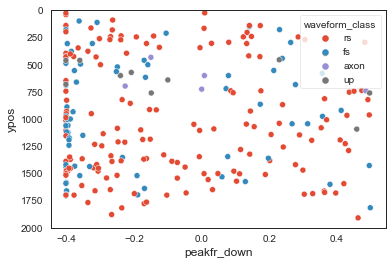

In [322]:
sns.scatterplot(x='peakfr_down',y='ypos',data=df_align,hue='waveform_class')
plt.ylim(2000,0)

# plot results

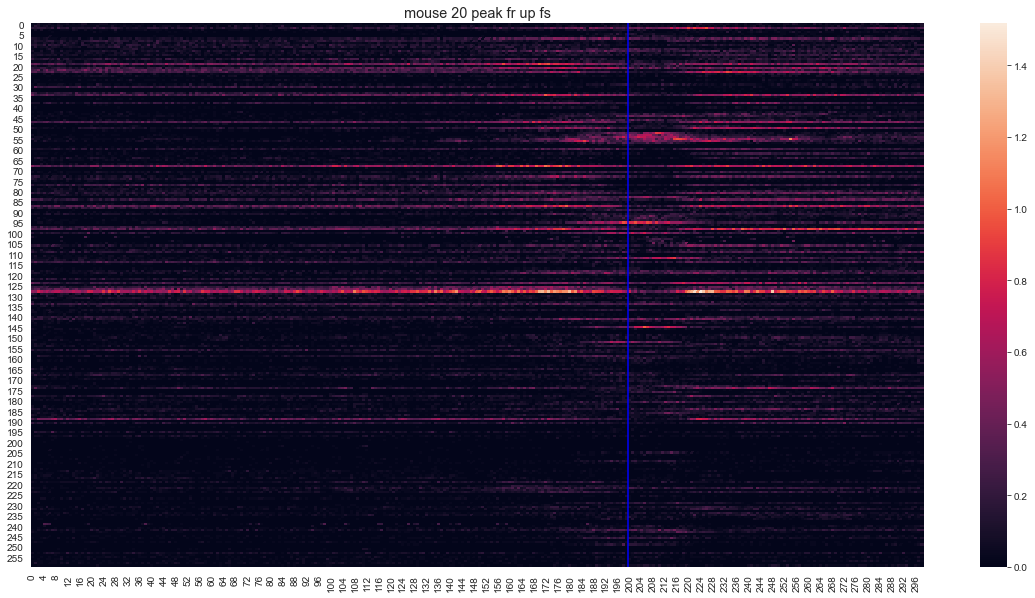

In [432]:
#make sure to change mouse number in save path for all figures
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(ave_reach)
plt.gca().axvline(200,c='b',ls='-')
plt.title('mouse 20 peak fr up fs')
plt.show()
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/move_mod_heatmaps/20_fs_peakup.png'
#fig.savefig(save_path) #CHANGE MOUSE NUMBER BEFORE RUNNING

### 

In [237]:
df_top = df_align[df_align.ypos>965]
df_bottom = df_align[df_align.ypos<965]


In [49]:
ev_s = ev

In [433]:
plt.plot(ev_f[0:20])
plt.plot(ev_s[0:20])
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/ev/'
#plt.savefig(save_path+str('20_ev_bot')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING


NameError: name 'ev_f' is not defined

In [65]:
traj_s = traj

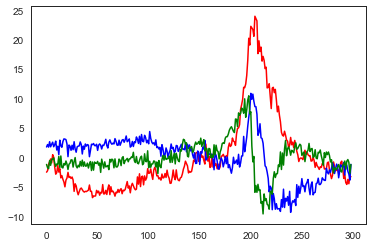

In [55]:
plt.plot(traj_f[0],'r')
plt.plot(traj_f[1],'b')
plt.plot(traj_f[2],'g')
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/pcs_time/'
#plt.savefig(save_path+str('20_bot')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING


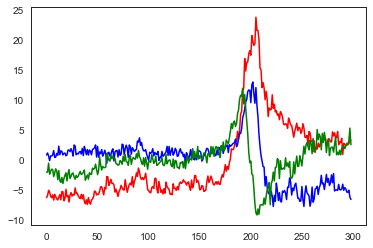

In [66]:
plt.plot(traj_s[0],'r')
plt.plot(traj_s[1],'b')
plt.plot(traj_s[2],'g')
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/pcs_time/'
#plt.savefig(save_path+str('20_bot')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

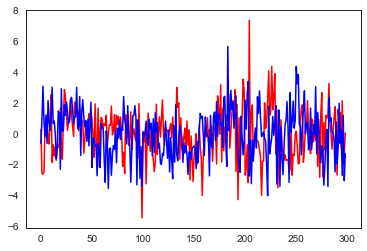

In [94]:
plt.plot(traj_f[10],'r')
plt.plot(traj_s[10],'b')

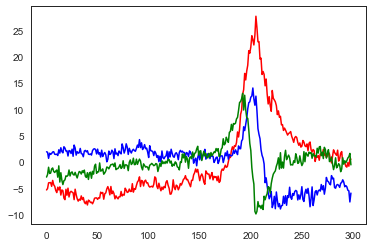

In [32]:
plt.plot(traj[0],'r')
plt.plot(traj[1],'b')
plt.plot(traj[2],'g')
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/pcs_time/'
#plt.savefig(save_path+str('20_bot')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

In [274]:
centr_traj = center(ave_reach_)
traj,ev = pca(centr_traj)
#smooth_pcs = gaussian_filter1d(p, sigma=8)

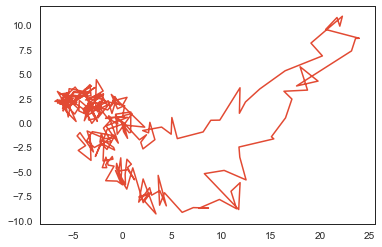

In [56]:
plt.plot(traj_f[0],traj_f[1])
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/2d/'
#plt.savefig(save_path+str('20_bot')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

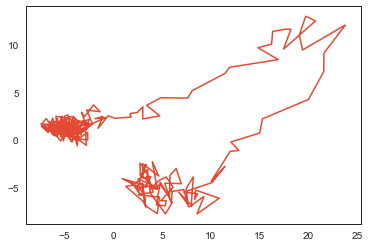

In [67]:
plt.plot(traj_s[0],traj_s[1])
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/2d/'
#plt.savefig(save_path+str('20_bot')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

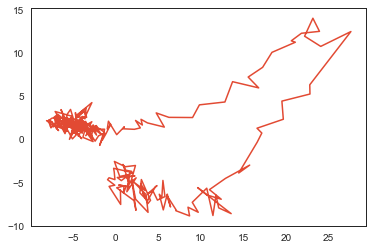

In [33]:
plt.plot(traj_f[0],traj_f[1])
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/2d/'
#plt.savefig(save_path+str('20_bot')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING


Text(0.5, 0.92, 'failure')

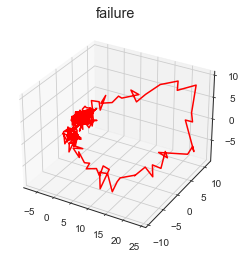

In [68]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(traj_f[0],traj_f[1],traj_f[2],'r')
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/3d/' 
#plt.savefig(save_path+str('20_bot_3d')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING
plt.title('failure')


NameError: name 'traj_s' is not defined

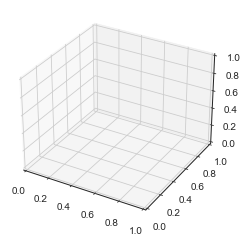

In [434]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(traj_s[0],traj_s[1],traj_s[2],'r')
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/3d/' 
#plt.savefig(save_path+str('20_bot_3d')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING
plt.title('success')


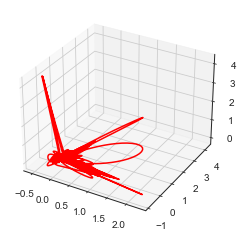

In [435]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(traj[0],traj[1],traj[2],'r')
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/figs/3d/' 
#plt.savefig(save_path+str('20_bot_3d')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING


# LDA

In [112]:
behavior = ['success','failure']

In [198]:
a = [traj_s.tolist()]
b = traj_f.tolist()

In [199]:
a.append(b)

In [200]:
df_reaches = pd.DataFrame(data=behavior, columns = ['behavior'])

In [201]:
df_reaches['traj'] = a

In [202]:
df_reaches

,behavior,traj
0,success,"[[-6.2812164178807555, -5.940362833904689, -5...."
1,failure,"[[-2.514880260009509, -2.265263268764326, -1.1..."


In [203]:
c = np.array(df_reaches.traj[0][0])
d = np.array(df_reaches.traj[1][0])

In [150]:
x = df_reaches.traj
metrics = []
for i,traj in enumerate(x):
    metrics.append(traj[0][0])

In [206]:
metrics = [c,d]

In [210]:
np.shape(metrics)

(2, 299)

In [209]:
labels

array([1., 0.])

In [208]:
#changed to dft_sorted
labels = np.zeros(np.shape(df_reaches)[0])
labels[np.array(df_reaches.behavior)=='success']=1
linear_quality = sq.project_linear_quality(metrics,labels)
lda_fail = linear_quality[labels==0]
lda_success = linear_quality[labels==1]
data = [lda_fail.flatten(), lda_success.flatten()]
d=plt.hist(data,bins=20,stacked=True)
plt.xlabel('overall quality',size=14);plt.ylabel('trajectory count',size=14);plt.title('LDA projection of all quality metrics, based on phy labels',size=14)

ValueError: The number of samples must be more than the number of classes.

In [153]:
from dlab import sorting_quality as sq
from sklearn.manifold import TSNE
from scipy.cluster.vq import kmeans2

import numpy as np
import seaborn as sns
import pandas as pd
import os, csv, time
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2 
sns.set_style("white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
dont run this cell, just save out each mouse individually using the .json line and the .csv lines
#df_align_total = pd.concat([df_align_total,df_align]) #concatenate multiple mice df_align // you can save df_align20 and df_align22 or just save out different mice individually via the csv, which would be df_align.to_csv('save_path')

# save as .json and .csv files

In [134]:
#CHANGE THE MOUSE NUMBER IN THE PATH: ('/where_you_are_saving_files/dfepoch_26.json')
#example
#df_align.to_json('/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/dfepoch_26.json')
df_align.to_json('/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/dfalign26.json')

In [ ]:
#CHANGE MOUSE NUMBER AGAIN IN NAME IN FIRST LINE AND AGAIN IN SAVEPATH IN TO_CSV
#example:
#df_align = pd.DataFrame(df_align,columns = ['ypos','mouse','cohort','cell','overall_rate','waveform_class','baseline_fr','reach_fr','mod_up','mod_down','peakfr_up','peakfr_down'])
#df_align.to_csv ('/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/dfepoch_26.csv')

df_align = pd.DataFrame(df_align,columns = ['ypos','mouse','cohort','cell','overall_rate','waveform_class','baseline_fr','reach_fr','mod_up','mod_down','peakfr_up','peakfr_down'])
df_align.to_csv ('/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/daileydata/dfepoch_mouse'NUMBER'.csv')

# ignore everything below (kim troubleshooting stuff)

0.24000000001615263

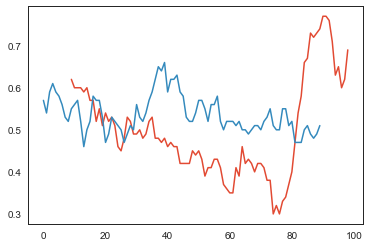

In [842]:
plt.plot(rolave_mfr)
plt.plot(rolave_mfrb)
maxfr_t
minfr_t

In [137]:
df_align_total

,times,ypos,mouse,cohort,cell,overall_rate,waveform_class,baseline_fr,reach_fr,bin_ave,norm_bin_ave,mod_up,mod_down,peakfr_up,peakfr_down
0,"[6.8355666667, 8.3678, 8.5388, 8.6099666667, 9...",20.000000,11,NPCC,0,5.529059,rs,5.020000,4.940000,"[0.13, 0.08, 0.09, 0.07, 0.12, 0.2, 0.13, 0.12...","[0.42857142857142855, 0.1904761904761905, 0.23...",yes,yes,0.40,0.24
1,"[0.0132, 0.07026666670000001, 0.20090000000000...",25.605773,11,NPCC,2,0.327134,rs,0.060000,0.080000,"[0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.01, 0.0, 0....","[0.0, 0.0, 0.0, 0.19999999999999998, 0.0, 0.19...",yes,no,-0.30,-0.41
2,"[198.9324333333, 247.0428, 259.2085, 285.24823...",20.000000,11,NPCC,3,5.217943,fs,6.480000,8.820000,"[0.06, 0.07, 0.05, 0.08, 0.06, 0.07, 0.08, 0.0...","[0.06666666666666667, 0.10000000000000002, 0.0...",yes,no,0.28,-0.40
3,"[46.919, 47.311, 47.4985666667, 47.7872666667,...",20.000000,11,NPCC,4,1.667360,rs,1.700000,1.430000,"[0.01, 0.06, 0.02, 0.06, 0.03, 0.06, 0.02, 0.0...","[0.08333333333333334, 0.5, 0.16666666666666669...",no,yes,-0.35,0.12
4,"[1842.2464666667, 1962.0448333333, 2049.593533...",96.940941,11,NPCC,6,0.025190,fs,0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",yes,no,-0.41,-0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,"[0.7947666667000001, 1.1270666667, 1.822766666...",1699.442220,20,NPCD,672,2.067259,rs,3.681818,6.409091,"[0.06818181818181818, 0.045454545454545456, 0....","[0.14285714285714285, 0.09523809523809523, 0.2...",yes,no,0.18,-0.37
232,"[738.4620666667, 738.5779666667, 738.602766666...",1699.442220,20,NPCD,674,0.891446,rs,0.181818,0.454545,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0227272727272...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, ...",yes,no,-0.33,-0.11
233,"[958.0217666667, 965.1398, 966.0326333333, 966...",1685.651121,20,NPCD,676,0.469189,rs,0.500000,1.227273,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,yes,0.20,0.32
234,"[7.8436666667, 10.4352333333, 10.988, 11.0623,...",1685.651121,20,NPCD,677,1.587944,rs,3.590909,7.409091,"[0.0, 0.045454545454545456, 0.0454545454545454...","[0.0, 0.11764705882352942, 0.11764705882352942...",yes,no,0.17,-0.21


In [185]:
binsize = 0.050
start = 0.5
end = 0.5

edges=np.arange(-start,end,binsize)
print(edges)

[-5.00000000e-01 -4.50000000e-01 -4.00000000e-01 -3.50000000e-01
 -3.00000000e-01 -2.50000000e-01 -2.00000000e-01 -1.50000000e-01
 -1.00000000e-01 -5.00000000e-02 -1.11022302e-16  5.00000000e-02
  1.00000000e-01  1.50000000e-01  2.00000000e-01  2.50000000e-01
  3.00000000e-01  3.50000000e-01  4.00000000e-01  4.50000000e-01]


In [186]:
jpsth = sum(byreach,axis=0)
print(jpsth)

[ 5.  6.  6.  8.  4.  5.  6.  6.  5.  0.  6.  2.  4.  7. 10. 14. 20. 18.
  8.]


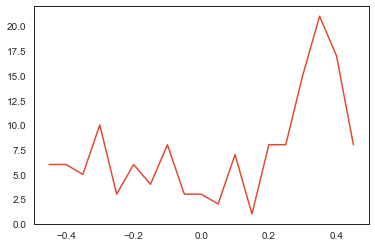

In [189]:
plt.plot(edges[1:],psth)
#plt.plot(edges[1:],jpsth)

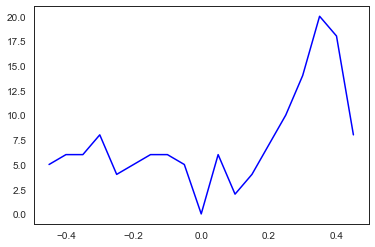

In [190]:
plt.plot(edges[1:],jpsth,'b')

In [175]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tqdm #for progress bars

In [180]:
def jitter(train,binsize):
    start = np.min(train) - (binsize/2.)
    end = np.max(train) + binsize
    bin_left_edges = np.arange(start,end,binsize)
    to = [train1[np.where((train1 < bin_left_edges[i+1]) & (train1 > bin_left_edges[i]))[0]] - bin_left_edges[i]  for i in tqdm.tqdm(range(len(bin_left_edges)-1))]
    #finds indices for which train1 is within each bin
    all_to = np.concatenate(to).ravel()
    jittered = []
    spike_indices = np.arange(all_to.shape[0]).tolist()
    np.random.shuffle(spike_indices) #shuffles bins
    for i,bin_ in tqdm.tqdm(enumerate(to)):
        spikes = []
        for spike in bin_:
            spikes.extend([all_to[spike_indices.pop(0)]])
        jittered.append(np.array(spikes) + bin_left_edges[i])
    jittered = np.concatenate(jittered).ravel()
    return jittered

  0%|          | 0/70714 [01:24<?, ?it/s]


In [371]:
startb = -1.5
endb = -0.5
starte = -0.5
ende = 0.5
binsize=0.001
    
edgesb=np.arange(startb,endb,binsize)
num_binsb=edgesb.shape[0]-1 #number of bins

edgese=np.arange(starte,ende,binsize)
num_binse=edgese.shape[0]-1 #number of bins

byreach_b=np.zeros((len(df_reaches.rMax_t),num_binsb))
byreach_e=np.zeros((len(df_reaches.rMax_t),num_binse))

mod_up = []
mod_down = []
maxfr_ts = []
minfr_ts = []

t = np.array(df.times[1])
    
for j,tmax in enumerate(df_reaches.rMax_t): 
        
    base = np.array(t[(t >= tmax+startb) & (t <= tmax+endb)])
    epoch = np.array(t[(t >= tmax+starte) & (t <= tmax+ende)])
        
    edgesb = np.arange(tmax+startb,tmax+endb,binsize)
    edgese = np.arange(tmax+starte,tmax+ende,binsize)
        
    histb=np.histogram(base,edgesb)[0] 
    histe=np.histogram(epoch,edgese)[0]
    
    byreach_b[j,:] = histb
    byreach_e[j,:] = histe
    
meanbinfr_b = np.mean(byreach_b,axis=0)
mfrb_ser = pd.Series(meanbinfr_b)        
rolave_mfrb = mfrb_ser.rolling(100).sum() #takes sum of 100bins, shifts 1bin .. 100 bins binned at 1 ms = 100ms summed bins
rolave_mfrb = np.array(rolave_mfrb.dropna())
#lower_,upper_ = sms.DescrStatsW(rolave_mfrb).tconfint_mean() #fix this
upper = np.mean(rolave_mfrb) + (2.56*std(rolave_mfrb))
lower = np.mean(rolave_mfrb) - (2.56*std(rolave_mfrb))

meanbinfr_e = np.mean(byreach_e,axis=0)
mfr_ser = pd.Series(meanbinfr_e)        
rolave_mfr = mfr_ser.rolling(100).sum() #takes sum of 10bins, shifts 1bin .. 10 bins binned at 10 ms = 100msbins
rolave_mfr = np.array(rolave_mfr.dropna())
maxfr_t = edgese[np.argmax(rolave_mfr)]-tmax
minfr_t = edgese[np.argmin(rolave_mfr)]-tmax
        
maxfr_ts.append(maxfr_t)
minfr_ts.append(minfr_t)

mfr_a = np.array(rolave_mfr)
up = np.where(mfr_a >= upper)[0].tolist()
down = np.where(mfr_a <= lower)[0].tolist()

consec_up = np.array(countlist(up))
consec_down = np.array(countlist(down))

if any(consec_up >= 50):
    ups = 'yes'
    mod_up.append(ups)
else:
    ups_ = 'no'
    mod_up.append(ups_)
    
if any(consec_down >= 50):
    downs = 'yes'
    mod_down.append(downs)
else:
    downs_ = 'no'
    mod_down.append(downs_)

In [355]:
edgese=np.arange(starte,ende,binsize)
num_binse=edgese.shape[0]-1 #number of bins
print(num_binse)

999


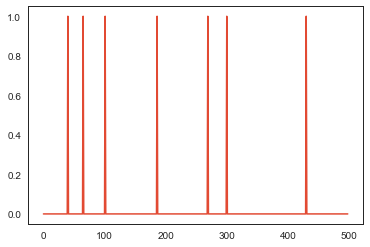

In [357]:
plt.plot(byreach_b[7])

1.1869336792031888 1.9894077842114475


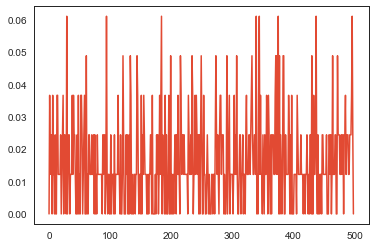

In [358]:
#plt.plot(rolave_mfrb)
plt.plot(meanbinfr_b)
print(lower,upper)

1.1483498176061524 1.870837174263768


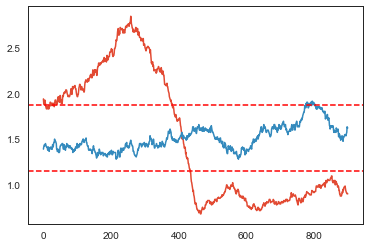

In [372]:
plt.plot(rolave_mfr)
plt.plot(rolave_mfrb)
np.shape(rolave_mfr)
print(lower,upper)
plt.gca().axhline(upper,c='r',ls='--')
plt.gca().axhline(lower,c='r',ls='--')

In [360]:
df.waveform_class[1]

'fs'

In [361]:
mod_down

['yes']

In [362]:
mod_up

['yes']